# imports

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sn
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse import hstack, vstack

from sklearn.neural_network import MLPClassifier
import pickle

import nltk
import re

import os
import json
import math

# global parameters

In [2]:
random_seed = 2020
np.random.seed(random_seed)

input_data_dir = f'{os.getcwd()}\\option1-data'
features_data_dir = f'{os.getcwd()}\\features-data'
model_data_dir = f'{os.getcwd()}\\model-data'
output_data_dir = f'{os.getcwd()}\\submission-data'

iterations = 20
model_file_name = f'model_{iterations}.sav'

# functions for data preprocessing and feature extraction

In [3]:
def id_preprocessing(data = None):
    df_id = data['id']
    ids = df_id.to_numpy().reshape((data.shape[0], 1))
    ids = sparse.csr_matrix(ids)
    return ids

In [4]:
def train_input_data_preprocessing(data = None):
    
    df_id = data['id']
    ids = df_id.to_numpy()
    df_tid1 = data['tid1']
    tid1s = df_tid1.to_numpy()
    df_tid2 = data['tid2']
    tid2s = df_tid2.to_numpy()
    df_title1_en = data['title1_en']
    title1_ens = df_title1_en.to_numpy()
    df_title2_en = data['title2_en']
    title2_ens = df_title2_en.to_numpy()
    
    length_data = data.shape[0]
    
    dict_title_ens = dict()
    for index in range(length_data):
        dict_title_ens[tid1s[index]] = title1_ens[index]
        dict_title_ens[tid2s[index]] = title2_ens[index]
    
    dict_tokens_articles = dict()
    for key_article in dict_title_ens.keys():
        text_article = dict_title_ens[key_article]
        corpus_article = nltk.sent_tokenize(text_article)
        for index in range(len(corpus_article)):
            corpus_article[index] = corpus_article[index].lower()
            corpus_article[index] = re.sub(r'\W', ' ', corpus_article[index])
            corpus_article[index] = re.sub(r'\s+', ' ', corpus_article[index])
        tokens_article = ""
        for sentence_article in corpus_article:
            tokens = nltk.word_tokenize(sentence_article)
            for token in tokens:
                tokens_article += f'{token} '
        dict_tokens_articles[key_article] = tokens_article.strip()
    
    keys = dict_tokens_articles.keys()
    values = dict_tokens_articles.values()
    
    cv=CountVectorizer() 
    word_count_vector = cv.fit_transform(values)
    tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True) 
    tf_idf_transformer.fit(word_count_vector)
    count_vector = cv.transform(values) 
    tf_idf_vectors = tf_idf_transformer.transform(count_vector)
    
    dict_tf_idf_vectors = dict()
    for k,v in zip(keys, tf_idf_vectors):
        dict_tf_idf_vectors[k] = v
    
    features = sparse.csr_matrix(np.empty((0, (len(cv.get_feature_names())*2)+1)))
    for index in range(length_data):
        print(index)
        fa_id = tid1s[index]
        ca_id = tid2s[index]
        fa_v = dict_tf_idf_vectors[fa_id]
        ca_v = dict_tf_idf_vectors[ca_id]
        vs = vstack([fa_v, ca_v])
        cs = cosine_similarity(vs, dense_output=True)[0][1]
        v = hstack([fa_v, cs, ca_v])
        features = vstack([features, v])
    
    return features

In [5]:
def test_input_data_preprocessing(data_train = None, data_test = None):
    
    df_id = data_train['id']
    ids = df_id.to_numpy()
    df_tid1 = data_train['tid1']
    tid1s = df_tid1.to_numpy()
    df_tid2 = data_train['tid2']
    tid2s = df_tid2.to_numpy()
    df_title1_en = data_train['title1_en']
    title1_ens = df_title1_en.to_numpy()
    df_title2_en = data_train['title2_en']
    title2_ens = df_title2_en.to_numpy()
    
    length_data = data_train.shape[0]
    
    dict_title_ens = dict()
    for index in range(length_data):
        dict_title_ens[tid1s[index]] = title1_ens[index]
        dict_title_ens[tid2s[index]] = title2_ens[index]
    
    dict_tokens_articles = dict()
    for key_article in dict_title_ens.keys():
        text_article = dict_title_ens[key_article]
        corpus_article = nltk.sent_tokenize(text_article)
        for index in range(len(corpus_article)):
            corpus_article[index] = corpus_article[index].lower()
            corpus_article[index] = re.sub(r'\W', ' ', corpus_article[index])
            corpus_article[index] = re.sub(r'\s+', ' ', corpus_article[index])
        tokens_article = ""
        for sentence_article in corpus_article:
            tokens = nltk.word_tokenize(sentence_article)
            for token in tokens:
                tokens_article += f'{token} '
        dict_tokens_articles[key_article] = tokens_article.strip()
    
    keys = dict_tokens_articles.keys()
    values = dict_tokens_articles.values()
    
    cv=CountVectorizer()
    word_count_vector = cv.fit_transform(values)
    tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tf_idf_transformer.fit(word_count_vector)

    df_id = data_test['id']
    ids = df_id.to_numpy()
    df_tid1 = data_test['tid1']
    tid1s = df_tid1.to_numpy()
    df_tid2 = data_test['tid2']
    tid2s = df_tid2.to_numpy()
    df_title1_en = data_test['title1_en']
    title1_ens = df_title1_en.to_numpy()
    df_title2_en = data_test['title2_en']
    title2_ens = df_title2_en.to_numpy()
    
    length_data = data_test.shape[0]
    
    dict_title_ens = dict()
    for index in range(length_data):
        dict_title_ens[tid1s[index]] = title1_ens[index]
        dict_title_ens[tid2s[index]] = title2_ens[index]
    
    dict_tokens_articles = dict()
    for key_article in dict_title_ens.keys():
        text_article = dict_title_ens[key_article]
        corpus_article = nltk.sent_tokenize(text_article)
        for index in range(len(corpus_article)):
            corpus_article[index] = corpus_article[index].lower()
            corpus_article[index] = re.sub(r'\W', ' ', corpus_article[index])
            corpus_article[index] = re.sub(r'\s+', ' ', corpus_article[index])
        tokens_article = ""
        for sentence_article in corpus_article:
            tokens = nltk.word_tokenize(sentence_article)
            for token in tokens:
                tokens_article += f'{token} '
        dict_tokens_articles[key_article] = tokens_article.strip()
    
    keys = dict_tokens_articles.keys()
    values = dict_tokens_articles.values()

    count_vector = cv.transform(values)
    tf_idf_vectors = tf_idf_transformer.transform(count_vector)
    
    dict_tf_idf_vectors = dict()
    for k,v in zip(keys, tf_idf_vectors):
        dict_tf_idf_vectors[k] = v
    
    features = sparse.csr_matrix(np.empty((0, (len(cv.get_feature_names())*2)+1)))
    for index in range(length_data):
        print(index)
        fa_id = tid1s[index]
        ca_id = tid2s[index]
        fa_v = dict_tf_idf_vectors[fa_id]
        ca_v = dict_tf_idf_vectors[ca_id]
        vs = vstack([fa_v, ca_v])
        cs = cosine_similarity(vs, dense_output=True)[0][1]
        v = hstack([fa_v, cs, ca_v])
        features = vstack([features, v])
    
    return features

In [6]:
def output_data_preprocessing(data = None):
    
    df_label = data['label']
    output_labels = df_label.to_numpy()
    
    label_encoder = preprocessing.LabelEncoder()
    integer_encoded = label_encoder.fit_transform(output_labels)
    
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    labels = onehot_encoded
    labels = sparse.csr_matrix(labels)
    
    return labels

# load training data

In [7]:
train_data_file = f'{input_data_dir}\\train.csv'
df_train_data = pd.read_csv(f'{train_data_file}')
print(df_train_data.shape)

(256442, 6)


# training data preprocessing and feature extraction

In [8]:
train_ids = id_preprocessing(data = df_train_data)

train_features = None
if os.path.exists(f'{features_data_dir}\\train-features.npz'):
    train_features = sparse.load_npz(f'{features_data_dir}\\train-features.npz').tocsr()
else:
    train_features = train_input_data_preprocessing(data = df_train_data)
    sparse.save_npz(f'{features_data_dir}\\train-features.npz', train_features)

train_labels = output_data_preprocessing(data = df_train_data)

print(train_ids.shape)
print(train_features.shape)
print(train_labels.shape)

(256442, 1)
(256442, 81237)
(256442, 3)


# train model

In [9]:
model = None

if os.path.exists(f'{model_data_dir}\\{model_file_name}'):
    model = pickle.load(open(f'{model_data_dir}\\{model_file_name}', 'rb'))
else:
    model = MLPClassifier(
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        batch_size=128,
        hidden_layer_sizes=(100), 
        random_state=random_seed,
        verbose=True,
        shuffle=True,
        max_iter=iterations
    )
    model.fit(train_features, train_labels)
    pickle.dump(model, open(f'{model_data_dir}\\{model_file_name}', 'wb'))

score = model.score(train_features, train_labels)
print(f'Train Accuracy : {score}')

C:\Users\yashm\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\yashm\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train Accuracy : 0.9983894993799768


In [10]:
pred = model.predict(train_features).todense()

labels = ['agreed', 'disagreed', 'unrelated']
train_pred = list()

for i in range(train_ids.shape[0]):
    label = None
    if pred[i, 0] == 1:
        label = labels[0]
    elif pred[i, 1] == 1:
        label = labels[1]
    elif pred[i, 2] == 1:
        label = labels[2]
    if label == None:
        label = labels[2]
    train_pred.append(np.array([train_ids[i,0], label]))

train_pred = np.array(train_pred)
train_pred_df = pd.DataFrame(train_pred, columns = ['id', 'label'])

           agreed  disagreed  unrelated
agreed      74128          0        110
disagreed      13       6550         43
unrelated     122         31     175445


<AxesSubplot:>

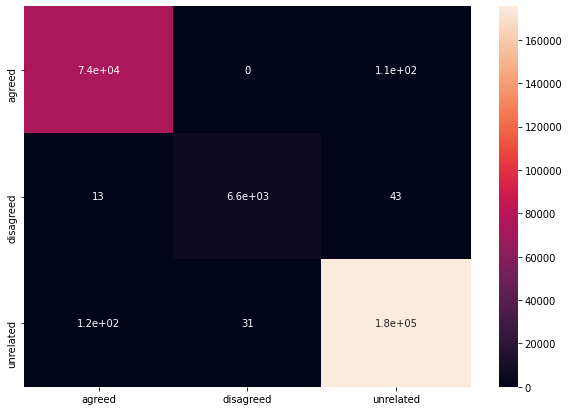

In [11]:
cm = confusion_matrix(df_train_data['label'].to_numpy().tolist(), train_pred_df['label'].to_numpy().tolist(), labels=['agreed', 'disagreed', 'unrelated'])
df_cm = pd.DataFrame(cm, index = ['agreed', 'disagreed', 'unrelated'], columns = ['agreed', 'disagreed', 'unrelated'])
print(df_cm)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [12]:
prfs = precision_recall_fscore_support(df_train_data['label'].to_numpy().tolist(), train_pred_df['label'].to_numpy().tolist(), labels=['agreed', 'disagreed', 'unrelated'], average=None)
prfs = np.array(prfs)
df_prfs = pd.DataFrame(prfs.T, index = ['agreed', 'disagreed', 'unrelated'], columns = ['precision', 'recall', 'fscore', 'support'])
print(df_prfs)

           precision    recall    fscore   support
agreed      0.998182  0.998518  0.998350   74238.0
disagreed   0.995289  0.991523  0.993403    6606.0
unrelated   0.999129  0.999129  0.999129  175598.0


# load testing data

In [16]:
test_data_file = f'{input_data_dir}\\test.csv'
df_test_data = pd.read_csv(f'{test_data_file}')
print(df_test_data.shape)

(64110, 5)


# testing data preprocessing and feature extraction

In [19]:
test_ids = id_preprocessing(data = df_test_data).todense()

test_features = None
if os.path.exists(f'{features_data_dir}\\test-features.npz'):
    test_features = sparse.load_npz(f'{features_data_dir}\\test-features.npz').tocsr()
else:
    test_features = test_input_data_preprocessing(data_train = df_train_data, data_test = df_test_data)
    sparse.save_npz(f'{features_data_dir}\\test-features.npz', test_features)

print(test_ids.shape)
print(test_features.shape)

(64110, 1)
(64110, 81237)


In [26]:
pred = model.predict(test_features).todense()

labels = ['agreed', 'disagreed', 'unrelated']
test_pred = list()

for i in range(test_ids.shape[0]):
    label = None
    if pred[i, 0] == 1:
        label = labels[0]
    elif pred[i, 1] == 1:
        label = labels[1]
    elif pred[i, 2] == 1:
        label = labels[2]
    if label == None:
        label = labels[2]
    test_pred.append(np.array([test_ids[i,0], label]))

test_pred = np.array(test_pred)
test_pred_df = pd.DataFrame(test_pred, columns = ['id', 'label'])

header = ['id','label']
test_pred_df.to_csv(f'{output_data_dir}\\submission_mlp_{iterations}.csv', columns = header,index=False)